# SpikeInterface - Intan Data

We will be using the `spikeinterface` version>0.90 

# Table of contents

* [0. Preparation](#preparation)
* [1. Loading the data and probe information](#loading)
* [2. Preprocessing](#preprocessing)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Spike sorting](#spike-sorting)
* [5. Extracting waveforms](#waveforms)
* [6. Postprocessing](#postprocessing)
* [7. Validation and curation](#curation)
* [8. Spike sorting comparison](#comparison)
* [9. Exporters](#exporters)

# 0. Preparation <a class="anchor" id="preparation"></a>

### Import the modules

Let's now import the `spikeinterface` modules that we need:

In [1]:
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.ndimage import gaussian_filter1d
import warnings

%matplotlib inline

# 1. Loading recording and probe information <a class="anchor" id="loading"></a>

In [3]:
# file path
recording_file = '3782_week8_REF_300_5k_16112021_211116_180416.rhd'

In [4]:
recording = se.read_intan(recording_file)

In [5]:
print(recording)

IntanRecordingExtractor: 32 channels - 1 segments - 30.0kHz - 180.454s
  file_path: 3782_week8_REF_300_5k_16112021_211116_180416.rhd


Here we `annotate` the recording to tell SpikeInterface that it is not filtered yet. This will prevent further mistakes in the pipieline, such as attempting to extract waveforms from unfiltered data.

In [6]:
recording.annotate(is_filtered=False)

Here we load information from the recording using the built-in functions from the RecordingExtractor

In [7]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_segments = recording.get_num_segments()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 30000.0
Number of channels: 32
Number of segments: 1


**NEW:** The new SI version supports multi-segment recordings. A segment is a contiguous piece of data, and sometimes recordings can be made of multiple acquisitions, for examples a baseline, a stimulation phase, and a post recording. In such cases, the recording object will be made of multiple segments and be treated as such over the pipeline.

The `get_traces()` function returns a TxN numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [8]:
trace_snippet = recording.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [9]:
print('Traces shape:', trace_snippet.shape)
#sw.plot_timeseries?

Traces shape: (60000, 32)


The `widgets` module includes several convenient plotting functions that can be used to explore the data:

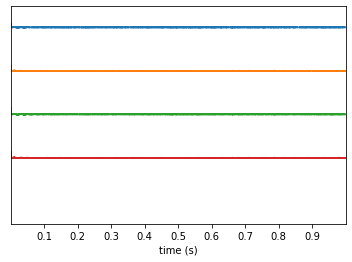

In [10]:
w_ts = sw.plot_timeseries(recording, channel_ids=['0', '1', '2', '3'], mode='auto')

Before moving on with the analysis, we have to load the probe information. For this we will use the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html) package. 

ProbeInterface allows to easily create, manipulate, and visualize neural probes. Moreover, it comes with a wide range of IO functions to import and export existing formats. Finally, we have created a public library of commercial probes (https://gin.g-node.org/spikeinterface/probeinterface_library/) that can be retrieved with a single line of code.

Let's import `probeinterface`, download the probe and plot it!

In [11]:
from probeinterface import Probe, ProbeGroup, read_prb
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import generate_dummy_probe
from probeinterface import write_probeinterface, read_probeinterface
from probeinterface import write_prb, read_prb

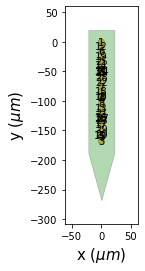

In [12]:
probe = read_prb('32chElectrodeLayouts.prb')
print(probe)
probe.to_dataframe(complete=True).loc[:, ["contact_ids" ,"device_channel_indices"]]
plot_probe_group(probe, same_axes=False, with_channel_index=True)

In [13]:
recording_prb = recording.set_probegroup(probe)

Note that also the `shank_id` is loaded with the probe.

**NEW:** A `probeinterface` object can be loaded directly to a SI recording object:

When loading the probe, the device indices (and all the other contact properties) are automatically sorted:

In [14]:
print(f'Channels after loading the probe file: {recording_prb.get_channel_ids()}')
print(f'Channel groups after loading the probe file: {recording_prb.get_channel_groups()}')

Channels after loading the probe file: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Channel groups after loading the probe file: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Properties 

`RecordingExtractor` object can have *properties*. A property is a piece of information attached to a channel, e.g. group or location.

Similarly, for `SortingExtractor` objects (that we'll cover later), anything related to a unit can be stored as a property. 

We can check which properties are in the extractor as follows:

In [15]:
print("Properties before loading the probe:", list(recording.get_property_keys()))

Properties before loading the probe: ['gain_to_uV', 'offset_to_uV', 'channel_name']


In [16]:
print("Properties after loading the probe:", list(recording_prb.get_property_keys()))

Properties after loading the probe: ['gain_to_uV', 'offset_to_uV', 'channel_name', 'contact_vector', 'location', 'group']


We can also specify a property on a subset of channels. In this case, the non-specified channels will be filled empty values:

In [17]:
recording_prb.set_property(key='quality', values=["good"]*(recording_prb.get_num_channels() - 3),
                           ids=recording_prb.get_channel_ids()[:-3])

In [18]:
recording_prb.get_property("quality")

array(['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', '', '', ''], dtype='<U4')

In [19]:
print("Properties after adding custom properties:", list(recording_prb.get_property_keys()))

Properties after adding custom properties: ['gain_to_uV', 'offset_to_uV', 'channel_name', 'contact_vector', 'location', 'group', 'quality']


**NOTE:** Internally the properties is jus a dictionary attached to the recording that is accessible as `_properties`

In [20]:
print(recording_prb._properties.keys())

dict_keys(['gain_to_uV', 'offset_to_uV', 'channel_name', 'contact_vector', 'location', 'group', 'quality'])


### Annotations

*Annotations* can be attached to any object and they can carry any information related to the recording or sorting objects.

Let's add an annotation about this tutorial:

In [21]:
recording_prb.annotate(description="Dataset Week 2 Acute")

In [22]:
print(recording_prb.get_annotation_keys())

['is_filtered', 'probe_0_planar_contour', 'description']


# 2. Preprocessing <a class="anchor" id="preprocessing"></a>

Here, we will filter the recording and apply common median reference (CMR). 

In [23]:
recordings_by_group = recording_prb.split_by("group")
print(recordings_by_group)

{0: ChannelSliceRecording: 32 channels - 1 segments - 30.0kHz - 180.454s}


In [24]:
recording_to_process = recordings_by_group[0]

Below, we bandpass filter the recording and apply common median reference to the original recording:

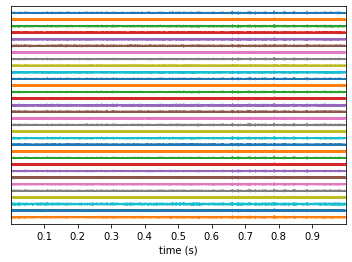

In [25]:
recording_f = st.bandpass_filter(recording_to_process, freq_min=00, freq_max=6000)

w = sw.plot_timeseries(recording_f)

We can see that the after filtering we can observe spiking activity on many channels! We can also apply other preprocessing steps to further increase the quality of the recording. 

Let's apply Common Median Reference (CMR)

In [26]:
recording_cmr = st.common_reference(recording_f, reference='global', operator='median')

We can plot the traces after applying CMR:

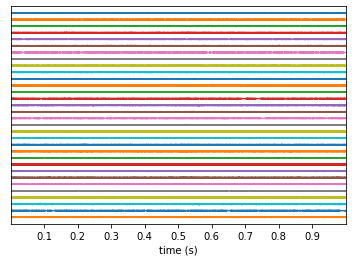

In [27]:
w = sw.plot_timeseries(recording_cmr)

In [28]:
fs = recording_cmr.get_sampling_frequency()
recording_sub = recording_cmr
#recording_sub = recording_cmr.frame_slice(start_frame=0*fs, end_frame=100*fs)

# 4. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording. We will use `herdingspikes` and `ironclust` for this demonstration, to show how easy SpikeInterface makes it easy to interchengably run different sorters :)

Let's first check the installed sorters in spiketoolkit to see if herdingspikes is available. Then we can then check the `herdingspikes` default parameters.
We will sort the bandpass cached filtered recording the `recoridng_saved` object.

In [29]:
ss.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'klusta',
 'mountainsort4',
 'pykilosort',
 'spykingcircus',
 'tridesclous',
 'waveclus',
 'yass']

In [30]:
ss.installed_sorters()

RUNNING SHELL SCRIPT: /var/folders/cr/g761k4_j3l18tdhlg3lfdrvm0000gn/T/tmp_shellscript072er2z1/script.sh


/Users/ismail/opt/anaconda3/envs/si090/lib/python3.8/site-packages/spikemetrics/metrics.py:15: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


['herdingspikes', 'mountainsort4', 'spykingcircus', 'tridesclous']

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `sorters` module:

In [31]:
#ss.get_default_params('herdingspikes')

In [32]:
#ss.get_params_description('herdingspikes')

In [33]:
#ss.run_sorter?

In [34]:
#ss.run_herdingspikes?

To modify a parameter, we can easily pass it to the `run` function as an extra argument!
For example, let's set the `filter` parameter to False as the recording is already preprocessed:

In [35]:
rec = recording_sub.save(folder="preprocessed")

write_binary_recording with n_jobs 1  chunk_size None


In [36]:
recording_loaded = si.load_extractor("preprocessed/")

In [37]:
# run spike sorting on entire recording
#sorting_HS = ss.run_herdingspikes(recording_cmr, output_folder='results_HS',raise_error=True, detect_threshold= 0)
#print('Found', len(sorting_HS.get_unit_ids()), 'units')

SpikeInterface ensures full provenance of the spike sorting pipeline. Upon running a spike sorter, a `spikeinterface_params.json` file is saved in the `output_folder`. This contains a `.json` version of the recording and all the input parameters. 

In [38]:
#!ls results_hs/

In [39]:
#!cat results_hs/spikeinterface_params.json

## Other sorters


In [40]:
#ss.installed_sorters()
#warnings.filterwarnings("ignore")

In [41]:
# run sorting on entire recording
sorting_MS = ss.run_mountainsort4(recording_loaded)
print('Found', len(sorting_MS.get_unit_ids()), 'units')
warnings.filterwarnings("ignore")

Mountainsort4 use the OLD spikeextractors mapped with NewToOldRecording


/Users/ismail/opt/anaconda3/envs/si090/lib/python3.8/site-packages/klusta/__init__.py:42: ResourceWarning: unclosed file <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
  __version_git__ = __version__ + _git_version()
/Users/ismail/opt/anaconda3/envs/si090/lib/python3.8/site-packages/spikemetrics/metrics.py:15: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d
/Users/ismail/opt/anaconda3/envs/si090/lib/python3.8/site-packages/klusta/__init__.py:42: ResourceWarning: unclosed file <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
  __version_git__ = __version__ + _git_version()
/Users/ismail/opt/anaconda3/envs/si090/lib/python3.8/site-packages/spikemetrics/metrics.py:15: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from sci

Found 37 units


In [42]:
#sorting_TS = ss.run_tridesclous(recording_loaded)
#print('Found', len(sorting_TS.get_unit_ids()), 'units')
#warnings.filterwarnings("ignore")

# Running multiple sorter jobs in parallel

So far we have seen how to run one sorter at a time. SI provides a convenient launcher in order to run multiple sorters on multiple recordings with one line of code!

The `run_sorters()` function of the `sorter` module allows you to specify a list of sorters to use on a list (or dictionary) of parameters. The jobs are by default ran in a loop, but the `engine` argument enables to specify a parallel backend (`joblib` or `dask`) and relative parameters.

In the following example, we run the 2 jobs to run `herdingspikes` and `ironclust` in parallel:

In [43]:
#sorting_outputs = ss.run_sorters(sorter_list=["mountainsort4", "tridesclous"],
#                                 recording_dict_or_list={"group0": recording_loaded},
#                                 working_folder="all_sorters",
#                                 verbose=False,
#                                 engine="joblib",
#                                 engine_kwargs={'n_jobs': 2})

The returned `sorting_outputs` variable is a dictionary that has (rec_name, sorter_name) as keys, and the `SortingExtractor` objects as valus:

In [44]:
#print(sorting_outputs.keys())

For the rest of the tutorial, let's pick the `ironclust` output:

In [45]:
#sorting_IC = sorting_outputs[('group0', 'ironclust')]

## Spike sort in Docker containers
###  (Linux and MacOS only)

Some sorters are hard to install! To alleviate this headache, SI provides a built-in mechanism to run a spike sorting job in a docker container.

We are maintaining a set of sorter-specific docker files in the [spikeinterface-dockerfiles repo](<https://github.com/SpikeInterface/spikeinterface-dockerfiles>)
and most of the docker images are available on Docker Hub from the [SpikeInterface organization](<https://hub.docker.com/orgs/spikeinterface/repositories>).

Running spike sorting in a docker container just requires to:

1. have docker installed
2. have docker python SDK installed (`pip install docker`)

When docker is installed, you can simply run the sorter in a specified docker image:

In [46]:
#print(ss.installed_sorters())

In [47]:
sorting_KL = ss.run_klusta(recording_loaded, output_folder="results_KL",
                                  docker_image="spikeinterface/klusta-base:0.2.7")
print('Found', len(sorting_KL.get_unit_ids()), 'units')

Found 6 units


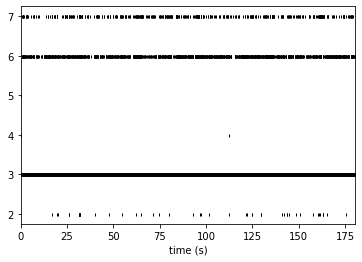

In [48]:
sw.plot_rasters(sorting_KL)

In [49]:
sorting_TC = ss.run_tridesclous(recording_loaded, output_folder="results_TC",
                                  docker_image="spikeinterface/tridesclous-base:1.6.4-1")
print('Found', len(sorting_TC.get_unit_ids()), 'units')

Found 1 units


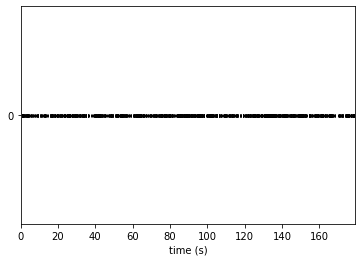

In [50]:
sw.plot_rasters(sorting_TC)

# 5. Extracting waveforms <a class="anchor" id="waveforms"></a>

The core of postprocessing spike sorting results revolves around extracting waveforms from paired recording-sorting objects.

To extract the waveforms, we can run:

In [51]:
#si.extract_waveforms?

extract waveforms: 100%|##########################| 1/1 [00:03<00:00,  3.59s/it]


WaveformExtractor: 32 channels - 37 units - 1 segments
  before:90 after:120 n_per_units:500


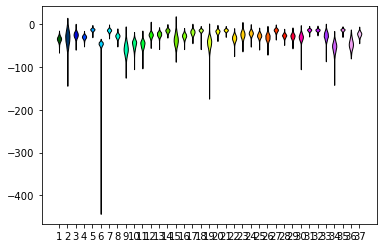

In [52]:
we_MS = si.extract_waveforms(recording_loaded, sorting_MS, folder="waveform_MS", progress_bar=True,
                          n_jobs=1, total_memory="500M", overwrite=True)
print(we_MS)
sw.plot_amplitudes_distribution(we_MS)

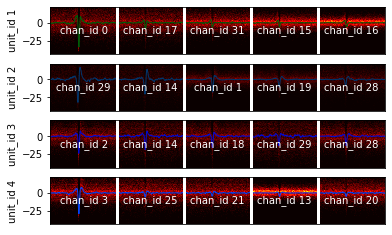

In [53]:
unit_ids = sorting_MS.unit_ids[:4]
sw.plot_unit_waveform_density_map(we_MS, unit_ids=unit_ids, max_channels=5)

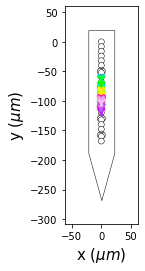

In [54]:
sw.plot_unit_localization(we_MS, method='center_of_mass')
plt.show()

extract waveforms: 100%|##########################| 1/1 [00:01<00:00,  1.20s/it]


WaveformExtractor: 32 channels - 6 units - 1 segments
  before:90 after:120 n_per_units:500


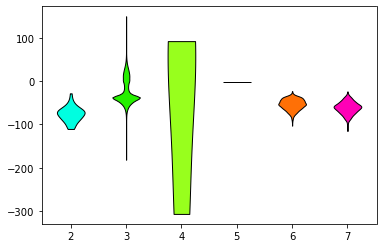

In [55]:
we_KL = si.extract_waveforms(recording_loaded, sorting_KL, folder="waveform_KL", progress_bar=True,
                          n_jobs=1, total_memory="500M", overwrite=True)
print(we_KL)
sw.plot_amplitudes_distribution(we_KL)

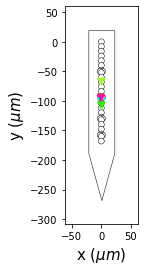

In [57]:
sw.plot_unit_localization(we_KL, method='center_of_mass')
plt.show()

extract waveforms: 100%|##########################| 1/1 [00:01<00:00,  1.29s/it]


WaveformExtractor: 32 channels - 1 units - 1 segments
  before:90 after:120 n_per_units:500


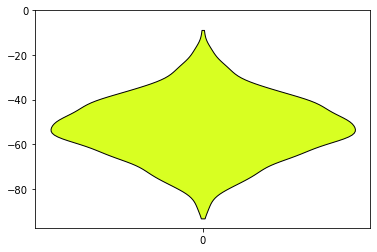

In [58]:
we_TC = si.extract_waveforms(recording_loaded, sorting_TC, folder="waveform_TC", progress_bar=True,
                          n_jobs=1, total_memory="500M", overwrite=True)
print(we_TC)
sw.plot_amplitudes_distribution(we_TC)

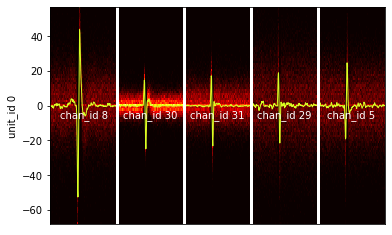

In [59]:
unit_ids = sorting_TC.unit_ids[:4]
sw.plot_unit_waveform_density_map(we_TC, unit_ids=unit_ids, max_channels=5)

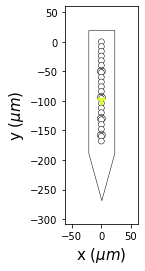

In [60]:
sw.plot_unit_localization(we_TC, method='center_of_mass')
plt.show()

Now all waveforms are computed and stored in the provided `wf_MS` folder. We can now retrieve waveforms and templates easily:

In [61]:
waveforms0_MS = we_MS.get_waveforms(unit_id=1)
print(f"Waveforms shape: {waveforms0_MS.shape}")
template0_MS = we_MS.get_template(unit_id=1)
print(f"Template shape: {template0_MS.shape}")
all_templates_MS = we_MS.get_all_templates()
print(f"All templates shape: {all_templates_MS.shape}")

Waveforms shape: (500, 210, 32)
Template shape: (210, 32)
All templates shape: (37, 210, 32)


In [62]:
waveforms0_KL = we_KL.get_waveforms(unit_id=2)
print(f"Waveforms shape: {waveforms0_KL.shape}")
template0_KL = we_KL.get_template(unit_id=2)
print(f"Template shape: {template0_KL.shape}")
all_templates_KL = we_KL.get_all_templates()
print(f"All templates shape: {all_templates_KL.shape}")

Waveforms shape: (47, 210, 32)
Template shape: (210, 32)
All templates shape: (6, 210, 32)


In [64]:
waveforms0_TC = we_TC.get_waveforms(unit_id=0)
print(f"Waveforms shape: {waveforms0_TC.shape}")
template0_TC = we_TC.get_template(unit_id=0)
print(f"Template shape: {template0_TC.shape}")
all_templates_TC = we_TC.get_all_templates()
print(f"All templates shape: {all_templates_TC.shape}")

Waveforms shape: (500, 210, 32)
Template shape: (210, 32)
All templates shape: (1, 210, 32)


For waveforms, the dimension is (num_spikes, num_samples, num_channels), while each template has dimension (num_samples, num_channels). Note that the number of spikes in this case is 500..we'll get back to it later!

The `WaveformExtractor` is also compatible with several `widgets` to visualize the spike sorting output:

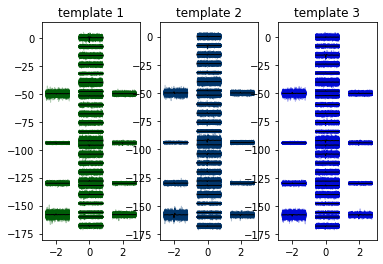

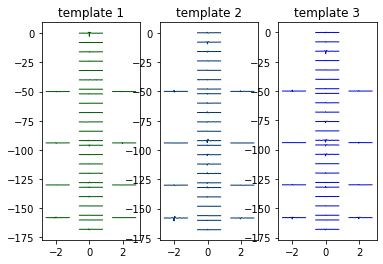

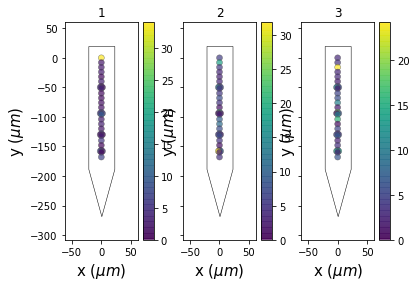

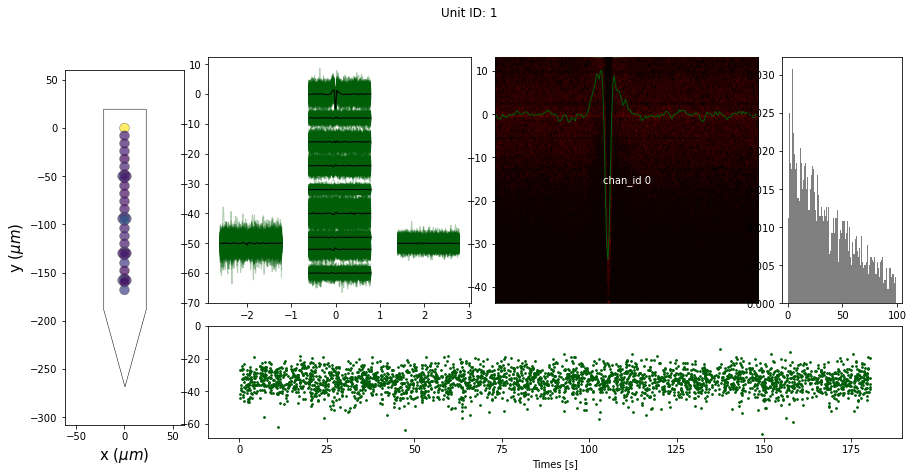

In [65]:
w_MS = sw.plot_unit_waveforms(we_MS, unit_ids=[1,2,3])
w_MS = sw.plot_unit_templates(we_MS, unit_ids=[1,2,3])
w_MS = sw.plot_unit_probe_map(we_MS, unit_ids=[1,2,3])
w_MS = sw.plot_unit_summary(we_MS, unit_id=1)

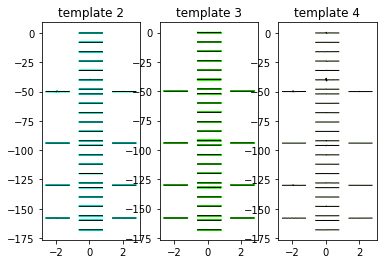

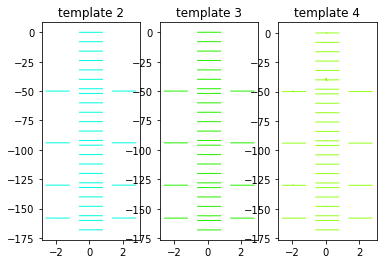

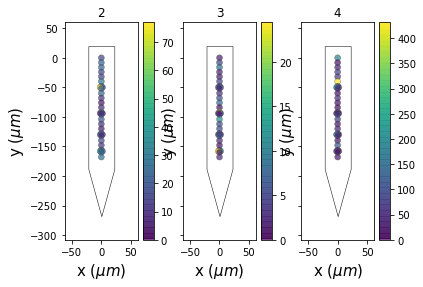

In [66]:
w_KL = sw.plot_unit_waveforms(we_KL, unit_ids=[2,3,4])
w_KL = sw.plot_unit_templates(we_KL, unit_ids=[2,3,4])
w_KL = sw.plot_unit_probe_map(we_KL, unit_ids=[2,3,4])
#w_KL = sw.plot_unit_summary(we_KL, unit_id = 5)

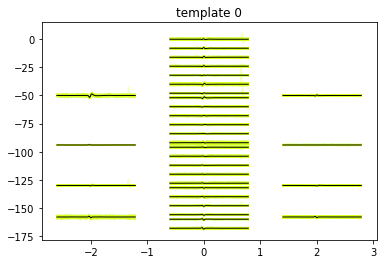

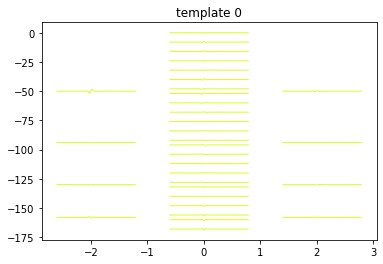

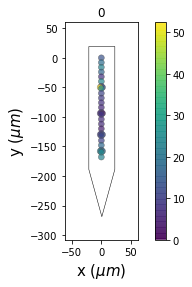

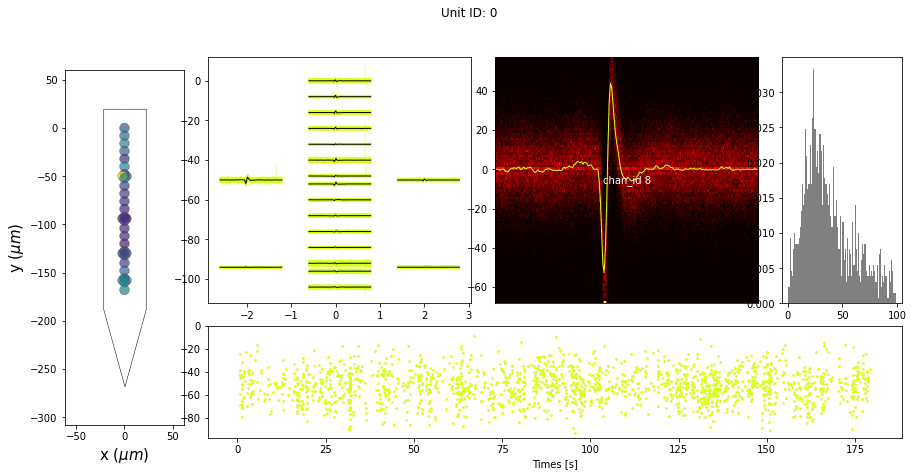

In [69]:
w_TC = sw.plot_unit_waveforms(we_TC, unit_ids=[0])
w_TC = sw.plot_unit_templates(we_TC, unit_ids=[0])
w_TC = sw.plot_unit_probe_map(we_TC, unit_ids=[0])
w_TC = sw.plot_unit_summary(we_TC, unit_id=0)

As we noticed before, the number of spikes for the waveforms is 500. Let's check the number of spikes for other waveforms:

In [70]:
for unit in sorting_MS.get_unit_ids():
    waveforms_MS = we_MS.get_waveforms(unit_id=unit)
    spiketrain_MS = sorting_MS.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms_MS.shape[0]} - num spikes: {len(spiketrain_MS)}")

Unit 1 - num waveforms: 500 - num spikes: 3161
Unit 2 - num waveforms: 500 - num spikes: 3362
Unit 3 - num waveforms: 500 - num spikes: 4033
Unit 4 - num waveforms: 500 - num spikes: 3923
Unit 5 - num waveforms: 500 - num spikes: 4165
Unit 6 - num waveforms: 500 - num spikes: 4137
Unit 7 - num waveforms: 500 - num spikes: 3646
Unit 8 - num waveforms: 500 - num spikes: 3907
Unit 9 - num waveforms: 500 - num spikes: 1758
Unit 10 - num waveforms: 500 - num spikes: 3644
Unit 11 - num waveforms: 500 - num spikes: 1803
Unit 12 - num waveforms: 500 - num spikes: 1523
Unit 13 - num waveforms: 500 - num spikes: 3250
Unit 14 - num waveforms: 500 - num spikes: 2703
Unit 15 - num waveforms: 500 - num spikes: 2714
Unit 16 - num waveforms: 500 - num spikes: 3897
Unit 17 - num waveforms: 500 - num spikes: 3728
Unit 18 - num waveforms: 500 - num spikes: 3681
Unit 19 - num waveforms: 500 - num spikes: 3708
Unit 20 - num waveforms: 500 - num spikes: 3535
Unit 21 - num waveforms: 500 - num spikes: 3711
U

In [71]:
for unit in sorting_KL.get_unit_ids():
    waveforms_KL = we_KL.get_waveforms(unit_id=unit)
    spiketrain_KL = sorting_KL.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms_KL.shape[0]} - num spikes: {len(spiketrain_KL)}")

Unit 2 - num waveforms: 47 - num spikes: 47
Unit 3 - num waveforms: 499 - num spikes: 151663
Unit 4 - num waveforms: 1 - num spikes: 3
Unit 5 - num waveforms: 0 - num spikes: 1
Unit 6 - num waveforms: 499 - num spikes: 1364
Unit 7 - num waveforms: 462 - num spikes: 462


In [72]:
for unit in sorting_TC.get_unit_ids():
    waveforms_TC = we_TC.get_waveforms(unit_id=unit)
    spiketrain_TC = sorting_TC.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms_TC.shape[0]} - num spikes: {len(spiketrain_TC)}")

Unit 0 - num waveforms: 500 - num spikes: 1771


No units have more than 500 spikes! This is because by default, the `WaveformExtractor` extracts waveforms on a random subset of 500 spikes. To extract waveforms on all spikes, we can use the `max_spikes_per_unit` argument:

In [73]:
we_all_MS = si.extract_waveforms(recording_loaded, sorting_MS, folder="waveform_MS_all_1", 
                              max_spikes_per_unit=None, progress_bar=True)

extract waveforms: 100%|##########################| 1/1 [00:16<00:00, 16.58s/it]


In [76]:
we_all_KL = si.extract_waveforms(recording_loaded, sorting_KL, folder="waveform_KL_all", progress_bar=True)

extract waveforms: 100%|##########################| 1/1 [00:01<00:00,  1.27s/it]


In [77]:
we_all_TC = si.extract_waveforms(recording_loaded, sorting_TC, folder="waveform_TC_all", 
                              max_spikes_per_unit=None, progress_bar=True)

extract waveforms: 100%|##########################| 1/1 [00:01<00:00,  1.16s/it]


In [78]:
for unit in sorting_MS.get_unit_ids():
    waveforms_MS = we_all_MS.get_waveforms(unit_id=unit)
    spiketrain_MS = sorting_MS.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms_MS.shape[0]} - num spikes: {len(spiketrain_MS)}")

Unit 1 - num waveforms: 3161 - num spikes: 3161
Unit 2 - num waveforms: 3362 - num spikes: 3362
Unit 3 - num waveforms: 4033 - num spikes: 4033
Unit 4 - num waveforms: 3923 - num spikes: 3923
Unit 5 - num waveforms: 4165 - num spikes: 4165
Unit 6 - num waveforms: 4137 - num spikes: 4137
Unit 7 - num waveforms: 3646 - num spikes: 3646
Unit 8 - num waveforms: 3907 - num spikes: 3907
Unit 9 - num waveforms: 1758 - num spikes: 1758
Unit 10 - num waveforms: 3644 - num spikes: 3644
Unit 11 - num waveforms: 1803 - num spikes: 1803
Unit 12 - num waveforms: 1523 - num spikes: 1523
Unit 13 - num waveforms: 3250 - num spikes: 3250
Unit 14 - num waveforms: 2703 - num spikes: 2703
Unit 15 - num waveforms: 2714 - num spikes: 2714
Unit 16 - num waveforms: 3897 - num spikes: 3897
Unit 17 - num waveforms: 3728 - num spikes: 3728
Unit 18 - num waveforms: 3681 - num spikes: 3681
Unit 19 - num waveforms: 3708 - num spikes: 3708
Unit 20 - num waveforms: 3535 - num spikes: 3535
Unit 21 - num waveforms: 3711

In [79]:
for unit in sorting_KL.get_unit_ids():
    waveforms_KL = we_all_KL.get_waveforms(unit_id=unit)
    spiketrain_KL = sorting_KL.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms_KL.shape[0]} - num spikes: {len(spiketrain_KL)}")

Unit 2 - num waveforms: 47 - num spikes: 47
Unit 3 - num waveforms: 499 - num spikes: 151663
Unit 4 - num waveforms: 1 - num spikes: 3
Unit 5 - num waveforms: 0 - num spikes: 1
Unit 6 - num waveforms: 499 - num spikes: 1364
Unit 7 - num waveforms: 462 - num spikes: 462


In [80]:
for unit in sorting_TC.get_unit_ids():
    waveforms_TC = we_all_TC.get_waveforms(unit_id=unit)
    spiketrain_TC = sorting_TC.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms_TC.shape[0]} - num spikes: {len(spiketrain_TC)}")

Unit 0 - num waveforms: 1771 - num spikes: 1771


Now waveforms have been extracted for all spikes! Let's move on to explore the postprocessing capabilities of the `toolkit` module.

# 6. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analisys (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `toolkit` module.

### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [81]:
pc_MS = st.compute_principal_components(we_MS, n_components=3)
pc0_MS = pc_MS.get_components(unit_id=1)
print(f"PC scores shape: {pc0_MS.shape}")
all_labels_MS, all_pcs_MS = pc_MS.get_all_components()
print(f"All PC scores shape: {all_pcs_MS.shape}")
warnings.filterwarnings("ignore")

PC scores shape: (500, 3, 32)
All PC scores shape: (18387, 3, 32)


In [82]:
pc_KL = st.compute_principal_components(we_KL, n_components=1)
pc0_KL = pc_KL.get_components(unit_id=2)
print(f"PC scores shape: {pc0_KL.shape}")
all_labels_KL, all_pcs_KL = pc_KL.get_all_components()
print(f"All PC scores shape: {all_pcs_KL.shape}")
warnings.filterwarnings("ignore")

PC scores shape: (47, 1, 32)
All PC scores shape: (1508, 1, 32)


In [83]:
pc_TC = st.compute_principal_components(we_TC, n_components=3)
pc0_TC = pc_TC.get_components(unit_id=0)
print(f"PC scores shape: {pc0_TC.shape}")
all_labels_TC, all_pcs_TC = pc_TC.get_all_components()
print(f"All PC scores shape: {all_pcs_TC.shape}")
warnings.filterwarnings("ignore")

PC scores shape: (500, 3, 32)
All PC scores shape: (500, 3, 32)


For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). 
The `get_all_components()` function returns an array with the label/unit id for each component (`all_labels`) and an array of dimension (num_all_samples, num_components, num_channels). 

### Spike amplitudes

By default, all amplitudes are concatenated in one array.

The correspinding spike times and labels can be easily retrieved as:

In [84]:
all_spike_times_MS, all_spike_labels_MS = sorting_MS.get_all_spike_trains()[0]
all_spike_times_KL, all_spike_labels_KL = sorting_KL.get_all_spike_trains()[0]
all_spike_times_TC, all_spike_labels_TC = sorting_TC.get_all_spike_trains()[0]

The [0] index is to select the first segment. In case of multiple segments each element will correspond to a different segment and will contain spike times and labels for that segment.


### Compute template metrics

Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `toolkit` allows one to compute several of these metrics:

In [85]:
print(st.get_template_metric_names())

['peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope']


In [86]:
template_metrics_MS = st.calculate_template_metrics(we_MS)
display(template_metrics_MS)

,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope
1,0.000167,-0.260835,0.00013,350126.083267,-12583.279655
2,0.000207,-0.556015,0.000157,299518.758837,-30463.915657
3,0.00016,-0.305497,0.00013,268410.060623,-10992.262966
4,0.000307,-0.26706,0.000133,289369.061682,-12358.701053
5,0.000147,-0.311484,0.000117,138009.968207,-4161.745357
6,0.000147,-0.314473,0.000117,535401.01619,-18610.469717
7,0.00015,-0.262592,0.00012,154861.469443,-4144.869675
8,0.000163,-0.267175,0.00013,281795.192898,-10474.270034
9,0.000183,-0.781296,0.000137,632545.03963,-66589.320708
10,0.000167,-0.35492,0.00013,497058.318582,-24673.991074


In [87]:
template_metrics_KL = st.calculate_template_metrics(we_KL)
display(template_metrics_KL)

,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope
2,0.0002,-1.012342,0.000143,820326.996507,-119040.717326
3,0.00019,-0.433396,0.000137,259661.13818,-18053.704163
4,0.00206,-0.093855,0.000097,959149.01958,-41202.45251
5,0.0,NaN,NaN,NaN,NaN
6,0.00019,-0.82208,0.000137,615158.066804,-69229.156481
7,0.000197,-0.909862,0.000143,662274.902654,-87658.698968


In [88]:
template_metrics_TC = st.calculate_template_metrics(we_TC)
display(template_metrics_TC)

,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope
0,0.000183,-0.825899,0.000137,573090.189478,-61355.34287


For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

# 7. Validation and curation <a class="anchor" id="curation"></a>

The `toolkit` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

Let's see what metrics are available:

In [89]:
print(st.get_quality_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff']


In [90]:
qc_MS = st.compute_quality_metrics(we_all_MS)
display(qc_MS)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_rate,isi_violations_count,amplitude_cutoff
1,3161,17.516891,1.00,3.081907,0.409361,0.376827,68,0.000082
2,3362,18.630745,1.00,0.206302,0.372519,0.387910,70,0.000077
3,4033,22.349136,1.00,2.718574,0.332838,0.498741,90,0.000064
4,3923,21.739564,1.00,3.397689,0.472928,0.670530,121,0.000114
5,4165,23.080623,1.00,2.940233,0.332880,0.531990,96,0.000062
6,4137,22.925459,1.00,3.369905,0.425266,0.670530,121,0.000063
7,3646,20.204550,1.00,2.991350,0.357470,0.437784,79,0.000071
8,3907,21.650899,1.00,3.028952,0.397998,0.559698,101,0.000915
9,1758,9.742073,1.00,4.471278,0.000000,0.000000,0,0.000147
10,3644,20.193467,1.00,3.615174,0.425811,0.520907,94,0.000725


In [91]:
qc_KL = st.compute_quality_metrics(we_all_KL)
display(qc_KL)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_rate,isi_violations_count,amplitude_cutoff
2,47,0.260454,0.32,5.463514,0.000000,0.000000,0,0.005506
3,151663,840.450551,1.00,1.462590,0.283565,600.894187,108434,0.101040
4,3,0.016625,0.02,4.922414,6683.496296,0.005542,1,0.000000
5,1,0.005542,0.01,NaN,0.000000,0.000000,0,NaN
6,1364,7.558696,1.00,4.027707,0.193985,0.033249,6,0.000520
7,462,2.560204,0.97,4.504066,0.845441,0.016625,3,0.015079


In [92]:
qc_TC = st.compute_quality_metrics(we_all_TC)
display(qc_TC)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_rate,isi_violations_count,amplitude_cutoff
0,1771,9.814114,1.0,0.688973,0.076713,0.022166,4,0.000146


For more information about these waveform features, we refer to this [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Automatic curation based on quality metrics

A viable option to curate (or at least pre-curate) a spike sorting output is to filter units based on quality metrics. As we have already computed quality metrics a few lines above, we can simply filter the `qc` dataframe based on some thresholds.

Here, we'll only keep units with an SNR > 5 and an ISI violation threshold < 0.2:

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

and then we can use the query to select units:

In [93]:
snr_thresh = 4  #4
isi_viol_thresh = 0.2   #.2

our_query = f"snr > {snr_thresh} & isi_violations_rate < {isi_viol_thresh}"
print(our_query)
print("")

print("For Mountainsort : ")
keep_units_MS = qc_MS.query(our_query)
keep_unit_ids_MS = keep_units_MS.index.values
sorting_auto_MS = sorting_MS.select_units(keep_unit_ids_MS)
print(f"Number of units before curation: {len(sorting_MS.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_MS.get_unit_ids())}")

print("For Klusta")
keep_units_KL = qc_KL.query(our_query)
keep_unit_ids_KL = keep_units_KL.index.values
sorting_auto_KL = sorting_KL.select_units(keep_unit_ids_KL)
print(f"Number of units before curation: {len(sorting_KL.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_KL.get_unit_ids())}")

print("For Tridesclous :")
keep_units_TC = qc_TC.query(our_query)
keep_unit_ids_TC = keep_units_TC.index.values
sorting_auto_TC = sorting_TC.select_units(keep_unit_ids_TC)
print(f"Number of units before curation: {len(sorting_TC.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_TC.get_unit_ids())}")

snr > 4 & isi_violations_rate < 0.2

For Mountainsort : 
Number of units before curation: 37
Number of units after curation: 1
For Klusta
Number of units before curation: 6
Number of units after curation: 4
For Tridesclous :
Number of units before curation: 1
Number of units after curation: 0


In [94]:
snr_thresh = 3  #4
isi_viol_thresh = 0.4   #.2

our_query = f"snr > {snr_thresh} & isi_violations_rate < {isi_viol_thresh}"
print(our_query)
print("")

print("For Mountainsort : ")
keep_units_MS = qc_MS.query(our_query)
keep_unit_ids_MS = keep_units_MS.index.values
sorting_auto_MS = sorting_MS.select_units(keep_unit_ids_MS)
print(f"Number of units before curation: {len(sorting_MS.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_MS.get_unit_ids())}")

print("For Klusta")
keep_units_KL = qc_KL.query(our_query)
keep_unit_ids_KL = keep_units_KL.index.values
sorting_auto_KL = sorting_KL.select_units(keep_unit_ids_KL)
print(f"Number of units before curation: {len(sorting_KL.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_KL.get_unit_ids())}")

print("For Tridesclous :")
keep_units_TC = qc_TC.query(our_query)
keep_unit_ids_TC = keep_units_TC.index.values
sorting_auto_TC = sorting_TC.select_units(keep_unit_ids_TC)
print(f"Number of units before curation: {len(sorting_TC.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_TC.get_unit_ids())}")

snr > 3 & isi_violations_rate < 0.4

For Mountainsort : 
Number of units before curation: 37
Number of units after curation: 5
For Klusta
Number of units before curation: 6
Number of units after curation: 4
For Tridesclous :
Number of units before curation: 1
Number of units after curation: 0


In [95]:
snr_thresh = 2  #4
isi_viol_thresh = 0.6   #.2

our_query = f"snr > {snr_thresh} & isi_violations_rate < {isi_viol_thresh}"
print(our_query)
print("")

print("For Mountainsort : ")
keep_units_MS = qc_MS.query(our_query)
keep_unit_ids_MS = keep_units_MS.index.values
sorting_auto_MS = sorting_MS.select_units(keep_unit_ids_MS)
print(f"Number of units before curation: {len(sorting_MS.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_MS.get_unit_ids())}")

print("For Klusta")
keep_units_KL = qc_KL.query(our_query)
keep_unit_ids_KL = keep_units_KL.index.values
sorting_auto_KL = sorting_KL.select_units(keep_unit_ids_KL)
print(f"Number of units before curation: {len(sorting_KL.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_KL.get_unit_ids())}")

print("For Tridesclous :")
keep_units_TC = qc_TC.query(our_query)
keep_unit_ids_TC = keep_units_TC.index.values
sorting_auto_TC = sorting_TC.select_units(keep_unit_ids_TC)
print(f"Number of units before curation: {len(sorting_TC.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_TC.get_unit_ids())}")

snr > 2 & isi_violations_rate < 0.6

For Mountainsort : 
Number of units before curation: 37
Number of units after curation: 28
For Klusta
Number of units before curation: 6
Number of units after curation: 4
For Tridesclous :
Number of units before curation: 1
Number of units after curation: 0


# 8. Comparison <a class="anchor" id="exporters"></a>

In [96]:
mcmp = sc.compare_multiple_sorters([sorting_MS,sorting_KL, sorting_TC], ['MS','KL', 'TC'], 
                                   spiketrain_mode='union', verbose=True)

Multicomaprison step 1: pairwise comparison
  Comparing: MS and KL


libc++abi: terminating with uncaught exception of type std::runtime_error: Couldn't close file
libc++abi: terminating with uncaught exception of type std::runtime_error: Couldn't close file
libc++abi: terminating with uncaught exception of type std::runtime_error: Couldn't close file


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [ ]:
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)
sw.plot_multicomp_graph(mcmp)

In [ ]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)

In [ ]:
cmp_MS_KL = sc.compare_two_sorters(sorting1=sorting_MS, sorting2=sorting_KL,sorting1_name='MS', 
                                        sorting2_name='KL')
cmp_TC_MS = sc.compare_two_sorters(sorting1=sorting_TC, sorting2=sorting_MS,sorting1_name='TC', 
                                        sorting2_name='MS')
cmp_TC_KL = sc.compare_two_sorters(sorting1=sorting_TC, sorting2=sorting_KL,sorting1_name='TC', 
                                        sorting2_name='KL')

In [ ]:
sw.plot_agreement_matrix(cmp_MS_KL)
sw.plot_agreement_matrix(cmp_MS_TC)
sw.plot_agreement_matrix(cmp_TC_KL)

In [ ]:
ms_to_kl, kl_to_ms = cmp_MS_KL.get_matching()

print('matching MS to KL')
print(ms_to_kl)
print('matching KL to MS')
print(kl_to_ms)

In [ ]:
ms_to_tc, tc_to_ms = cmp_MS_TC.get_matching()

print('matching MS to TC')
print(ms_to_tc)
print('matching TC to MS')
print(tc_to_ms)

In [ ]:
tc_to_kl, kl_to_tc = cmp_TC_KL.get_matching()

print('matching TC to KL')
print(tc_to_kl)
print('matching KL to TC')
print(kl_to_tc)

## Concensus Based comparison

In [ ]:
agr_2 = mcmp.get_agreement_sorting(minimum_agreement_count=2)
print('Units in agreement for all three sorters: ', agr_2.get_unit_ids())
print(agr_2.get_property('unit_ids'))

## Export to Phy for manual curation

To perform manual curation we can export the data to [Phy](https://github.com/cortex-lab/phy). 

In [97]:
from spikeinterface.exporters import export_to_phy

In [ ]:
export_to_phy(we_MS, output_folder='phy_MS',
              progress_bar=True, total_memory='100M')

write_binary_recording with n_jobs 1  chunk_size 1562500


extract PCs:  25%|########                        | 1/4 [00:35<01:45, 35.10s/it]

In [ ]:
export_to_phy(we_TC, output_folder='phy_TC',
              progress_bar=True, total_memory='100M')

In [ ]:
#%%capture --no-display
#!phy template-gui phy_IC/params.py

After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

In [ ]:
#sorting_MS_phy_curated = se.PhySortingExtractor('phy_IC/', exclude_cluster_groups=['noise'])

In [ ]:
#print(f"Number of units before curation: {len(sorting_MS.get_unit_ids())}")
# in manual curation, 3 units were labeled as noise:
#print(f"Number of units after curation: {len(sorting_MS_phy_curated.get_unit_ids())}")